In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras import Input
from tensorflow.keras.utils import plot_model, to_categorical
import numpy as np
import tensorflow as tf
from tensorflow import keras

# [4월 27일]
---

## # 함수형 API 소개
---

### # Sequential 모델
---

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input

seq_model = Sequential()
seq_model.add(Dense(32, activation = 'relu', input_shape = (64, )))
seq_model.add(Dense(32, activation = 'relu'))
seq_model.add(Dense(10, activation = 'softmax'))

seq_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 32)                1056      
                                                                 
 dense_16 (Dense)            (None, 10)                330       
                                                                 
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


### # 함수형 API 모델
---

In [ ]:
input_tensor = Input(shape = (64,))
x = Dense(32, activation = 'relu')(input_tensor)
x = Dense(32, activation = 'relu')(x)
output_tensor = Dense(10, activation = 'softmax')(x)

model = Model(input_tensor, output_tensor)

model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 32)                1056      
                                                                 
 dense_28 (Dense)            (None, 10)                330       
                                                                 
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


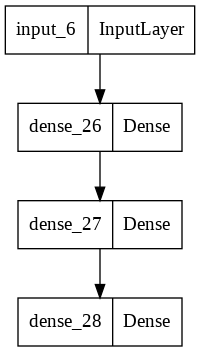

In [ ]:
# 모델 시각화

from tensorflow.keras.utils import plot_model

plot_model(model)

## # MNIST 이미지
---

### # 데이터 전처리
---

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train = X_train.reshape(60000, 784).astype('float32') / 255
X_test = X_test.reshape(10000, 784).astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

11501568/11490434 [==============================] - 0s 0us/step


### # 모델 구성
---
CategoricalCrossentropy vs SparseCategoricalCrossentropy
- 훈련 데이터의 label(target)이 one-hot vector 이면 CategoricalCrossentropy
- 훈련 데이터의 label(target)이 정수이면 SparseCategoricalCrossentropy


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

inputs = keras.Input(shape = (784, ), name = 'digit')
x = Dense(64, activation = 'relu', name = 'dense_1')(inputs)
x = Dense(64, activation = 'relu', name = 'desne_2')(x)
outputs = Dense(10, activation = 'softmax', name = 'predictions')(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer = keras.optimizers.RMSprop(),
              loss = keras.losses.SparseCategoricalCrossentropy(),
              metrics = [keras.metrics.SparseCategoricalAccuracy()])

history = model.fit(X_train, y_train,
                    batch_size = 64,
                    epochs = 2,
                    validation_data = (X_val, y_val))

Epoch 1/2
782/782 [==============================] - 5s 3ms/step - loss: 0.3387 - sparse_categorical_accuracy: 0.9028 - val_loss: 0.1811 - val_sparse_categorical_accuracy: 0.9513
Epoch 2/2
782/782 [==============================] - 2s 3ms/step - loss: 0.1609 - sparse_categorical_accuracy: 0.9517 - val_loss: 0.1343 - val_sparse_categorical_accuracy: 0.9611


In [ ]:
results = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1374 - sparse_categorical_accuracy: 0.9607


## # 다중 입력 모델
---

### # 2개의 입력을 가진 질문-응답 모델 구현
---

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 question (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, None, 64)     640000      ['text[0][0]']                   
                                                                                                  
 embedding_17 (Embedding)       (None, None, 32)     320000      ['question[0][0]']               
                                                                                           

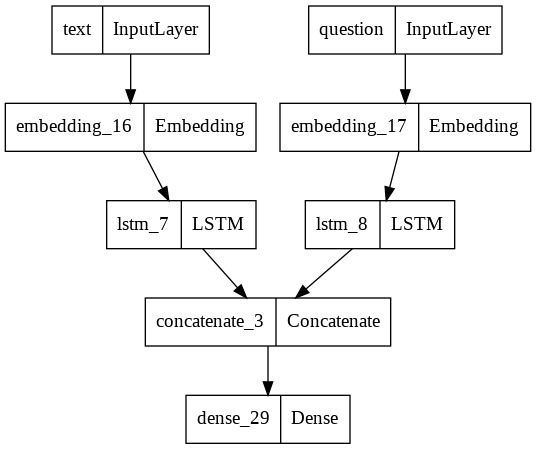

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input

text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# 텍스트 입력은 길이가 정해지지 않은 정수 시퀀스
text_input = Input(shape = (None, ), dtype = 'int32', name = 'text')

# 크기 64의 벡터 시퀀스로 임베딩
embedded_text = layers.Embedding(text_vocabulary_size, 64)(text_input)

# LSTM을 사용하여 이 벡터들을 하나의 벡터로 인코딩
encoded_text = layers.LSTM(32)(embedded_text)

# 질문도 텍스트와 동일한 과정을 거친다
question_input = Input(shape = (None, ), dtype = 'int32', name = 'question')
embedded_question = layers.Embedding(question_vocabulary_size, 32)(question_input)
encoded_question = layers.LSTM(16)(embedded_question)

# 인코딩된 질문과 텍스트를 연결
# axis = -1은 가장 낮은 차원에서부터 시작. 자료가 2차원이고 axis = -1이면 1차원에서 붙이라는 의미이다.
concatenated = layers.concatenate([encoded_text, encoded_question], axis = -1)

answer = layers.Dense(answer_vocabulary_size, activation = 'softmax')(concatenated)
model = Model([text_input, question_input], answer)
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

model.summary()

# 모델 시각화
from tensorflow.keras.utils import plot_model
plot_model(model)

### # 데이터 주입
---

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

num_samples = 1000
max_length = 100

text = np.random.randint(1, text_vocabulary_size, size = (num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size, size = (num_samples, max_length))

answers = np.random.randint(0, answer_vocabulary_size, size = num_samples)
answers = to_categorical(answers)

# 리스트 입력을 사용하여 학습
model.fit([text, question], 
          answers, 
          epochs = 10, 
          batch_size = 128) 

# 딕셔너리 입력을 사용하여 학습 (입력 이름을 지정했을 때만 사용 가능)
# model.fit({'text': text, 'question': question},
#           answers,
#           epochs = 10,
#           batch_size = 128)

Epoch 1/10
8/8 [==============================] - 5s 14ms/step - loss: 6.2149 - acc: 0.0020
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 6.1986 - acc: 0.0380
Epoch 3/10
8/8 [==============================] - 0s 14ms/step - loss: 6.1614 - acc: 0.0120
Epoch 4/10
8/8 [==============================] - 0s 13ms/step - loss: 6.0701 - acc: 0.0090
Epoch 5/10
8/8 [==============================] - 0s 13ms/step - loss: 6.0026 - acc: 0.0070
Epoch 6/10
8/8 [==============================] - 0s 13ms/step - loss: 5.8963 - acc: 0.0100
Epoch 7/10
8/8 [==============================] - 0s 13ms/step - loss: 5.7859 - acc: 0.0170
Epoch 8/10
8/8 [==============================] - 0s 16ms/step - loss: 5.6989 - acc: 0.0320
Epoch 9/10
8/8 [==============================] - 0s 13ms/step - loss: 5.6173 - acc: 0.0530
Epoch 10/10
8/8 [==============================] - 0s 13ms/step - loss: 5.5449 - acc: 0.0560


## # 다중 출력 모델
---

### # 3개의 출력을 가진 모델 구현
---

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D


vocabulary_size = 50000
num_income_groups = 10

posts_input = Input(shape = (None, ), dtype = 'int32', name = 'posts')
embedded_posts = Embedding(vocabulary_size, 256)(posts_input)
x = Conv1D(128, 5, activation = 'relu')(embedded_posts)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation = 'relu')(x)
x = Conv1D(128, 5, activation = 'relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation = 'relu')(x)
x = Conv1D(128, 5, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation = 'relu')(x)

# 출력층에 이름 지정
age_prediction = Dense(1, name = 'age')(x)
income_prediction = Dense(num_income_groups, activation = 'softmax', name = 'income')(x)
gender_prediction = Dense(1, activation = 'sigmoid', name = 'gender')(x)

model = Model(inputs = posts_input, outputs = [age_prediction, income_prediction, gender_prediction])

### # 다중 출력 모델의 컴파일 옵션
---

#### # 일반적인 구성
---

In [ ]:
model.compile(optimizer = 'rmsprop',
              loss = ['mse', 'categorical_crossentropy', 'binary_crossentropy'])

# 위와 동일하나 출력 층에 이름을 지정했을 때만 사용 가능
model.compile(optimizer = 'rmsprop',
              loss = {'age': 'mae',
                      'income': 'categorical_crossentropy',
                      'gender': 'binary_crossentropy'})

#### # 손실 가중치 추가
---

In [ ]:
model.compile(optimizer = 'rmsprop',
              loss = ['mse', 'categorical_crossentropy', 'binary_crossentropy'],
              loss_weights = [0.25, 1., 10.])

# 위와 동일하나 출력 층에 이름을 지정했을 때만 사용 가능
model.compile(optimizer = 'rmsprop',
              loss = {'age': 'mae',
                      'income': 'categorical_crossentropy',
                      'gender': 'binary_crossentropy'}
              loss_weights = {'age': 0.25,
                              'income': 1.,
                              'gender': 10.})

### # 데이터 주입
---

In [ ]:
# posts, age_targets, income_targets, gender_targets가 넘파이 배열이라고 가정
model.fit(posts, [age_targets, imcome_targets, gender_tagers],
          epochs = 10,
          batch_size = 64)

# 위와 동일하나 출력 층에 이름을 지정했을 때만
model.fit(posts,
          {'age': age_targets,
           'income': income_targets,
           'gender': gender_targets},
          epochs = 10,
          batch_size = 64)